In [1]:
import pandas as pd
import nltk
import gzip
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import random 
from matplotlib import pyplot
from pylab import rcParams
from IPython.display import HTML, display

rcParams['figure.figsize'] = 15, 10
np.random.seed(42)

# Introduction

In this notebook, we will explore opinion mining and sentiment analysis through the use of natural language processing. Our dataset consists of reviews of electronic products scraped form Amazon and available here: http://jmcauley.ucsd.edu/data/amazon/

The objective of this analysis is to use the reviews to extract meaningful characteristics about their respective product. Such characteristics can then be used to help the user make faster and more informed decisions when shopping on electronic commerce websites. The extracted characteristics consist of pairs of words that describe a property of the product such as its quality or performance. Those pairs are either of the type adjective-noun or adverb-past participle.

For example:

    Adjective - Nouns: (good, quality) (low, price) (best, deal)
    Adverb - Past Participle pairs such as (well, made) (poorly, assembled)

The characteristics can then be categorised into positive and negative opinions and shown to the subsequent potential buyers. This way, users can quickly be informed on the general trends and opinions formulated by previous clients about a particular product. 

## Table of Contents

<ol>
<li> <a href="#Data-Overview">Data Overview</a>
    <ol>
        <li><a href="#Reading-the-data">Reading the data</a></li>
        <li><a href="#Data-Overview">Formats</a></li>
        <li><a href="#Missing-values">Missing values</a></li>
        <li><a href="#Distributions">Distributions</a></li>
    </ol>
</li>
<p></p>
<li> <a href="#Characteristics-Extraction">Characteristics Extraction</a></li>
<p></p>
<li><a href="#Sentiment-Analysis">Sentiment Analysis</a></li>
<p></p>
        <li><a href="#Sentiment-Analysis,-revisited">Sentiment Analysis, revisited</a></li>
<p></p>
<li><a href="#Application-to-brand-names">Application to brand names</a></li>
</ol>

# Reading the data 
**<a href="#Table-of-Contents">Back to table of contents</a>**

For this intermediate milestone we will be using the following datasets:

1. Sample of electronic review (1,689,188 reviews)
2. Full dataset metadata

#### 1. Electronic reviews sample
Those easily fit in memory. Therefore, we can read the data line by line and store the result in a dataframe.
#### 2. Full dataset metadata
The metadata was downloaded from the cluster. It is not possible to load it in memory as when uncompressed it is more than 10GB in size. Since we care about electronic products for the moment, we read it line by line and only store the entries whose category is related to electronics. This results in a much smaller file of approx 500Mo (uncompressed) which can hold in memory.

## Scalability
We argue that processing the data locally will scale reasonably well to the rest of the Electronic reviews as our pipeline is applied separately for each product. That is, we only need to hold the reviews of one product as well as its metadata in memory at any given time.

## Code

### Reading the data file
To open the data file we reuse the python code given by the author of the dataset. (See http://jmcauley.ucsd.edu/data/amazon/)

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
        
def parseUncompressed(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    """
    Reads a data file and use it the build a DataFrame
    """
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Reading the metadata file

In [3]:
def metadata_for_category(path, category):
    """
    Reads the metadata file and extract only metadata for the given category
    path: The path to the metadata file
    category: The product category for which to extract the metadata
    
    Returns a DataFrame holding the metadata
    """
    i = 0
    df = {}
    for d in parseUncompressed(path):
        if 'categories' in d:
            for categories_list in d['categories']:
                if categories_list[0] == category:
                    df[i] = d
                    i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Loading and storing intermediate results
DataFrames' `to_pickle` and `read_pickle` are used to respectively save and load serialized version of our intermediate results. We use it for example to store only the Electronics metadata:

In [ ]:
df = metadata_for_category('data/metadata.json', 'Electronics')
df.to_pickle('data/metadata_electronics_serialized.pickle')

In [ ]:
df = getDF('data/reviews_Electronics_5.json.gz')
df.to_pickle('data/electronics_serialized.pickle')

# Data Overview
**<a href="#Table-of-Contents">Back to table of contents</a>**

We start by performing some basic statistical analysis on our data. By doing this, we seek to find if there are any unusual patterns which could be interesting in the context of our analysis.

In [78]:
df_elec = pd.read_pickle('data/electronics_serialized.pickle')

In [79]:
df_meta = pd.read_pickle('data/metadata_electronics_serialized.pickle')

### Formats

We will now describe the different formats:

In [81]:
df_elec['reviewTime']  = pd.to_datetime(df_elec['reviewTime'],format='%m %d, %Y')
df_elec.dtypes

summary                   object
reviewerName              object
reviewTime        datetime64[ns]
overall                  float64
asin                      object
helpful                   object
unixReviewTime             int64
reviewerID                object
reviewText                object
dtype: object

* summary: The summary of the product
* reviewerName: The reviewer name
* reviewTime: The review time in the datetime type
* overall: The rating of the product from 1 to 5 included
* asin: The id of the product
* helpfull: The helpfulness of the comment. It is stored as an array; the first element is the number of positive votes the second element is the total number of votes for the comment.
* unixReviewTime: The review time in the unix format
* reviewerID: The reviewer id
* reviewText: The text of the review

In [ ]:
df_meta = df_meta[pd.notnull(df_meta['brand'])]
df_meta.dtypes

* title: The name of the product
* description: The description of the product
* imUrl: The url of the image
* categories: The categories of the product, stored as an array
* asin: The id of the product
* price: The price of the product
* selesRank: The sales rank, stored as dictionary mapping the category to the rank
* related: The related products, stored as dictionary mapping a tag (also_bought, bought_together,...) to the asin
* brand: The name of the brand

### Missing values
**<a href="#Table-of-Contents">Back to table of contents</a>**

To plot the data, we discarded every null entries in price and reviewLength.

In [62]:
df_merged = df_meta.merge(df_elec, left_on='asin', right_on='asin', how='inner')
df_merged['reviewLength'] = df_merged['reviewText'].str.len()

df_plot = df_merged.copy()
df_plot = df_plot[pd.notnull(df_plot['price'])]
df_plot = df_plot[pd.notnull(df_plot['reviewLength'])]

### Distributions
**<a href="#Table-of-Contents">Back to table of contents</a>**

We plotted the scatter matrix of the price, the review length and the overall score, to have some insight on the global distribution of the data:

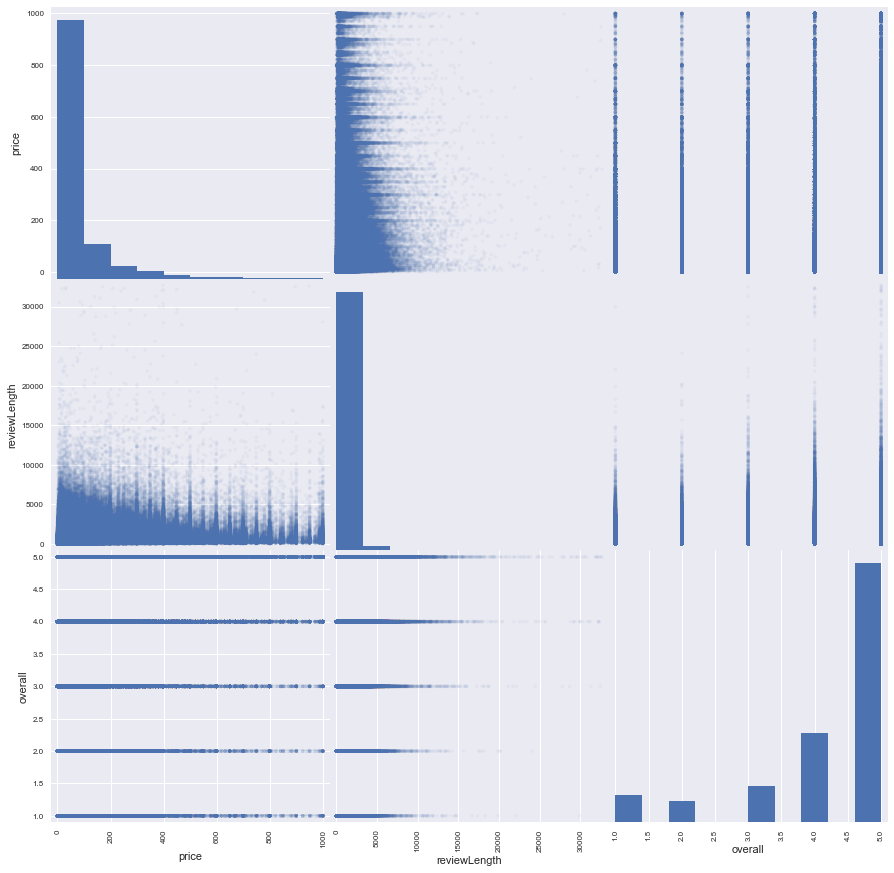

In [63]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_plot[['price','reviewLength','overall']], alpha=0.05, figsize=(15, 15), diagonal='hist')
plt.show()

We also plotted the price over the review length to see in more details the data. We can directly see that there is a lot of noise (as expected). We also see that most of the mass is concentrated in a rather small interval; indeed the median of the price is 28.5 and the median of the text length is 312.

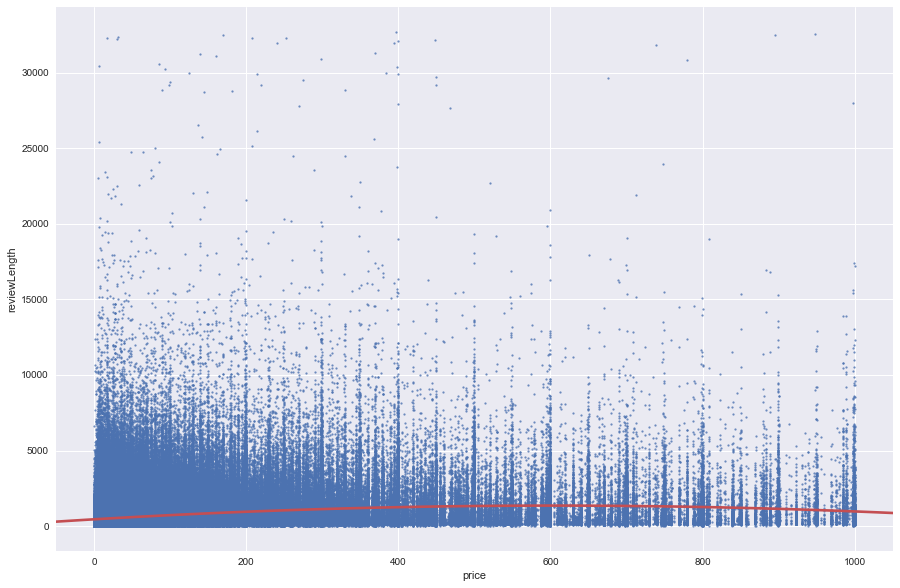

In [64]:
sns.regplot(y='reviewLength', x='price', data=df_plot,scatter_kws={'s':5},line_kws={'color':'r'},order=2)
plt.show()

We also plotted the distributions of the reviewLength over the overall rating. We can see that the extremes are less present in the data. Indeed, the review length is smaller for good reviews, this can be explained by the fact those reviews are synthetic: “Well made”, “Good Product”. The reviews that have a bad score (2) tend to be larger, as the critic can be quite extensive.

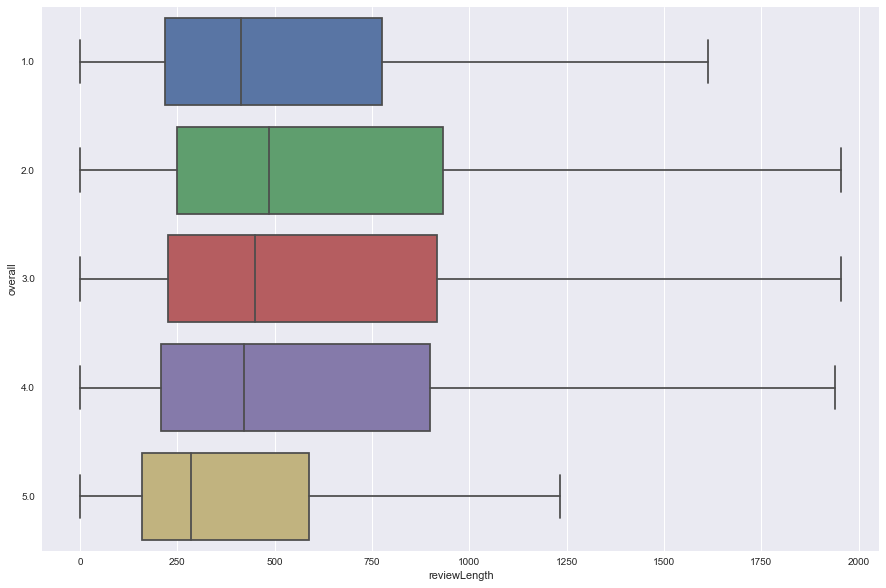

In [65]:
sns.boxplot(y='overall', x='reviewLength', data=df_plot, orient='h', showfliers=False)
plt.show()

Finally, we sought to understand the distribution of the price and the review length by plotting their density and the box plot.

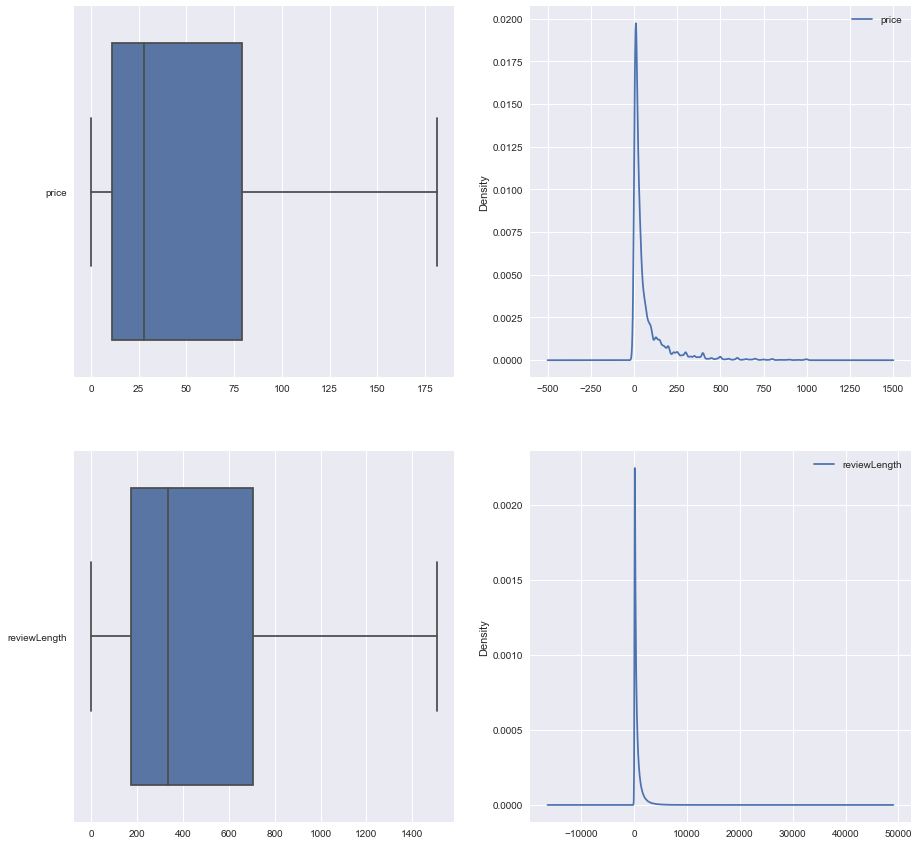

In [66]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.boxplot(data= df_plot[['price']],orient='h', showfliers=False,ax=axes[0,0])
df_plot[['price']].plot.kde(ax=axes[0,1])
sns.boxplot(data= df_plot[['reviewLength']],orient='h', showfliers=False,ax=axes[1,0])
df_plot[['reviewLength']].plot.kde(ax=axes[1,1])

plt.show()

We tried to fit a specific distribution; the exponential distribution to the data provided. We see that if we pick lambda = 65, we get a close approximation to the result.

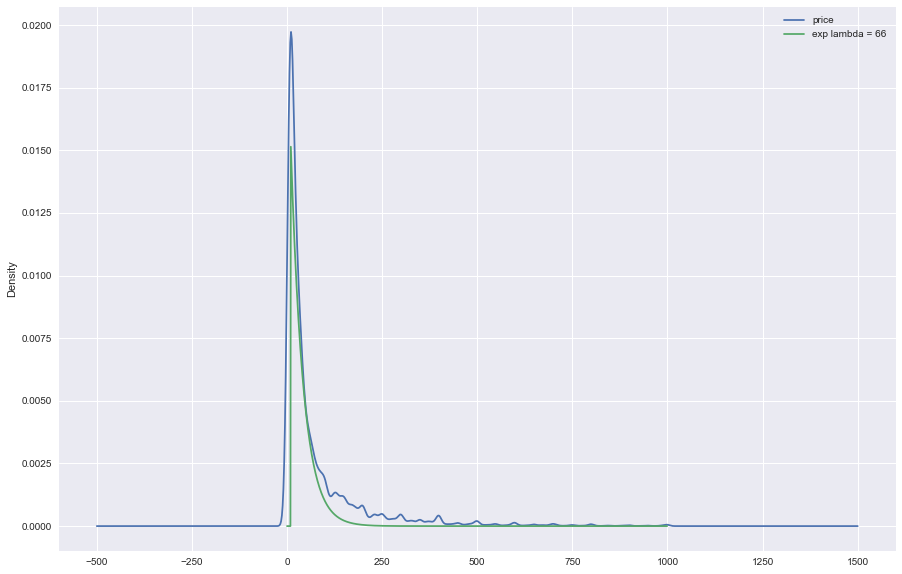

In [67]:
from scipy.stats import expon
import scipy.stats

d = df_plot[['price']]
ax = d.plot.kde()
x = ax.get_children()[0]._x
y = ax.get_children()[0]._y

scale = 66
loc = -480

pdf_fitted = expon.pdf(x - loc, scale=scale)
plt.plot(pdf_fitted,label= ('exp lambda = ' + str(scale)))
plt.legend(loc='best')
plt.show()

We tried to fit a specific distribution; the pareto distribution to the data provided. We see that if we pick b = 1, we get a close approximation to the result up to a multiplicative constant.

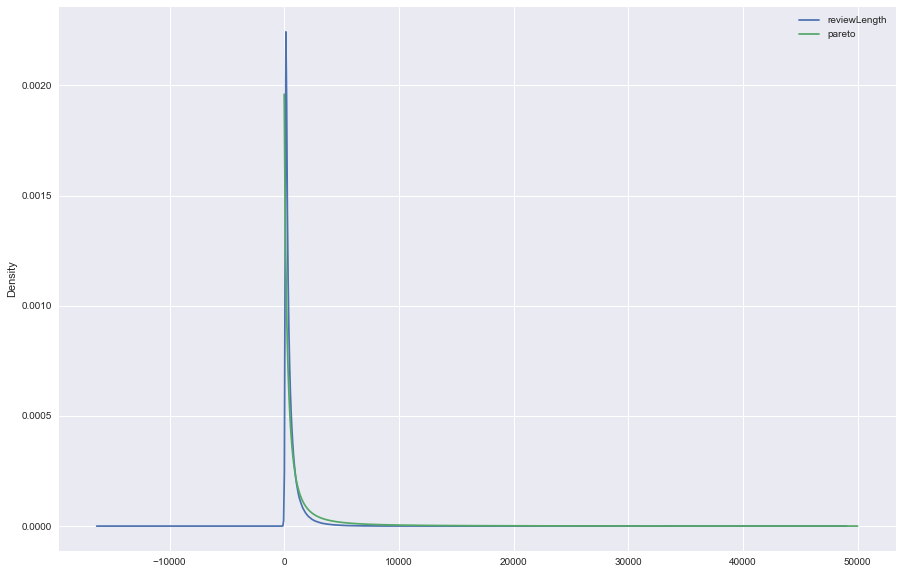

In [122]:
from scipy.stats import pareto
import scipy.stats

d = df_plot[['reviewLength']]
ax = d.plot.kde()

b = 1
x = np.linspace(pareto.ppf(0.01, b),pareto.ppf(0.99, b), 50000)
pdf_fitted = scipy.stats.pareto.pdf(x,b = b)/500
plt.plot(pdf_fitted,label= 'pareto')
plt.legend(loc='best')
plt.show()

### Correlations

We computed the correlation between the price, reviewLength, and the overall. We can see that the overall doesn't seem to be a lot correlated between the price and the review length. But more interestingly there seem to be some correlation between the price and the review lenght. Maybe the user are more passionate about the items they are willing to spend the more money on !

In [68]:
df_merged[['price','reviewLength','overall']].corr()

,price,reviewLength,overall
price,1.000000,0.220456,0.009223
reviewLength,0.220456,1.000000,-0.075206
overall,0.009223,-0.075206,1.000000


# Characteristics Extraction
**<a href="#Table-of-Contents">Back to table of contents</a>**

Now that we've acquired basic insight on our data, we will start describing the core of our project. We want to be able to extract opinions and product characteristics from reviews. One simple and effective way of doing that is to find adjective-nouns pairs that happen several times for a given product. Such pairs of words are also called collocations. Collocations are tuples of words that happen more frequently than one would expect if the words were distributed randomly in the text.

To find collocations, we use the [Natual Language Tool Kit (NLTK)](http://www.nltk.org/) package for Python. NLTK also provides an interface for the [WordNet](https://wordnet.princeton.edu/) lexical database.

WordNet can be used to find lexical relations between words. It is also capable of returning a part-of-speech (POS) tags for any given word. The nomenclature chosen for those tags is the open from the [Penn Treebank Project](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf). The tags used by our pipeline are the following:

Every tag starting with *JJ*: 
* JJ -	Adjective
* JJR -	Adjective, comparative
* JJS -	Adjective, superlative 

Every tag starting with *RB*:
* RB -	Adverb
* RBR - Adverb, comparative
* RBS - Adverb, superlative 
* VBN -	Verb, past participle 

Every tag starting with *NN*:
* NN -	Noun, singular or mass
* NNS -	Noun, plural
* NNP -	Proper noun, singular
* NNPS - Proper noun, plural 

Every tag starting with *VB*
* VB -	Verb, base form
* VBD -	Verb, past tense
* VBG -	Verb, gerund or present participle
* VBN -	Verb, past participle
* VBP -	Verb, non-3rd person singular present
* VBZ -	Verb, 3rd person singular present 

As explained in the introduction, we will extract pairs consisting of Adjective-Nouns (like "good quality"), Adverb - Past Participle (like "well made") and verb-adverb (like "works well"). 

In [49]:
def filterTags(w1,w2):
    """
    w1: First tagged word
    w2: Second tagged word
    
    Returns true if the bigram collocation is of type adjective-noun, adverb-past participle or verb-adverb
    """
    _, tag1 = nltk.pos_tag(nltk.word_tokenize(w1))[0]
    _, tag2 = nltk.pos_tag(nltk.word_tokenize(w2))[0]
    
    return  (tag1.startswith('JJ') and tag2.startswith('NN')) or \
            (tag1.startswith('RB') and tag2.startswith('VBN')) or \
            (tag1.startswith('VB') and tag2=="JJ")
        
def isImportantTag(tag):
    return tag[:2] in ['JJ', 'NN', 'RB', 'VBN', 'VB', 'JJ']
        
def filterTrigramTags(w1, w2, w3):
    """
    w1: First tagged word
    w2: Second tagged word
    w3: Third tagged word
    
    Returns true if each word in the trigram collocations is either an adjective, an adverb or a noun
    """
    
    _, tag1 = nltk.pos_tag(nltk.word_tokenize(w1))[0]
    _, tag2 = nltk.pos_tag(nltk.word_tokenize(w2))[0]
    _, tag3 = nltk.pos_tag(nltk.word_tokenize(w3))[0]
    
    return isImportantTag(tag1) and isImportantTag(tag2) and isImportantTag(tag3)


def bigram_correlations(finder):
    pass
    

import re, string

def getCollocations(text, window=2,  find_trigrams=False):
    """
    text: The concatenation of all the review for a given product
    
    Returns the collocations of words larger 
    """
    ignored_words = nltk.corpus.stopwords.words('english')
    
    brigram_res = []
    trigram_res = []
    
    pattern = re.compile('(\_)+')
    text = re.sub(pattern, " ", text)
    
    
    tokens = nltk.word_tokenize(text)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    
    bigram_finder = nltk.BigramCollocationFinder.from_words(tokens, window_size=window)
    
    # Ignore bigram that are infrequent
    bigram_finder.apply_freq_filter(3) 
    # Retrieves the 10 most common bigrams
    bigram_res = bigram_finder.nbest(bigram_measures.pmi, 10) 
    bigram_res = [(x,round(bigram_finder.score_ngram(bigram_measures.raw_freq, x[0], x[1]),2)*200) 
                  for x in bigram_res if filterTags(x[0],x[1])]
    
    if find_trigrams:
        trigram_finder = nltk.TrigramCollocationFinder.from_words(tokens)
        trigram_finder.apply_freq_filter(3)
        trigram_res = trigram_finder.nbest(trigram_measures.pmi, 10)
        trigram_res = [(x, round(trigram_finder.score_ngram(trigram_measures.pmi, x[0], x[1], x[2]), 2)*100/0.33)
                  for x in trigram_res if filterTrigramTags(x[0], x[1], x[2])]
    
    if(len(bigram_res) > 0 or len(trigram_res) > 0):
        return bigram_res + trigram_res
    else:
        return np.nan
    
getCollocations("")

And feed the reviews as described above.

In [95]:
df_product = df_elec.groupby(["asin"])['reviewText'].agg(lambda x:''.join(set(x.str.lower()))).reset_index()

In [51]:
from timeit import default_timer as timer
  
# Too slow if done sequentially
start = timer()

print(df_product["reviewText"].apply(getCollocations, args=(2, True,)).dropna(how='any'))
print(df_product["reviewText"].apply(getCollocations, args=(3, True,)).dropna(how='any'))

end = timer()
print(end - start)  

KeyboardInterrupt: 

## Increasing pipeline performance
The step of finding interesting collocations is by far the most computationnaly expensive and the bottleneck of our pipeline. However, there's a simple way of mitigating this. The key observation is that each product can be analyzed separately since we aggregate all reviews with their respective product. This means that we can parallelize the collocation finding algorithm over several products. Unfortunately, IPython notebooks do not support the use of multi-threaded code. We had to move it to the [ThreadedCollocations.py](ThreadedCollocations.py) file. The code there simply loads our dataset, setup a pool of 8 worker threads and call the function `getCollocations` on each product. Finally, it saves the resulting dataframe in a pickle file. The algorithm can parse all the 63k products (~1.6 million reviews)  in approximately 10 minutes on a laptop processor. We load the results from a pickle file below:

In [98]:
collocations = pd.read_pickle("elec_collocations.pickle")
collocations = collocations.dropna(how = 'any')
display(collocations.head())

,asin,reviewText
0,0528881469,"[((basic, garmin), 0.262)]"
3,0972683275,"[((retail, stores), 0.034), ((full, motion), 0..."
4,1400501466,"[((ad-supported, versions), 0.046), ((angry, b..."
6,1400501776,"[((full, android), 0.136)]"
7,1400532620,"[((visual, feedback), 0.04), ((few, hours), 0...."


In [99]:
df_product = df_product.copy().merge(collocations, left_on='asin', right_on='asin', how='inner')
df_product = df_product.rename(index=str, columns={"reviewText_y": "bigrams","reviewText_x":"reviewText"})
display(df_product.head())

,asin,text,bigrams,reviewText
0,0528881469,"not going to write a long review, even thought...","[((basic, garmin), 0.262)]","[((basic, garmin), 0.262)]"
1,0972683275,the directions stink. just remember the spacer...,"[((retail, stores), 0.034), ((full, motion), 0...","[((retail, stores), 0.034), ((full, motion), 0..."
2,1400501466,just picked up a refurbished nook tablet from ...,"[((ad-supported, versions), 0.046), ((angry, b...","[((ad-supported, versions), 0.046), ((angry, b..."
3,1400501776,purchased as a christmas gift for my son. he ...,"[((full, android), 0.136)]","[((full, android), 0.136)]"
4,1400532620,if anyone have used previous version of nook y...,"[((visual, feedback), 0.04), ((few, hours), 0....","[((visual, feedback), 0.04), ((few, hours), 0...."


We see that the characteristics extracted this way are already quite interesting. We see that some products were described several time as being of "high quality" or "well made". However, we also note that some bigrams found do not actually correspond to product characteristics. This happens for example when the users write compound words such as "hard drive". Since this pair of words happen quite often in review for hard drives, our pipeline mistakenly detects it as an interesting collocation.

## Filtering the results further

We propose the following simple solution to filter out words: *If the bigram can be found in an english dictionnary, then it is not an interesting collocation.*

This will for example filter out results such as "hard drive" or "optical mouse".

However, findind a list of modern english words is not an easy task. Almost every dataset that can be found on the internet does not include nouns relevant for our work (such as hard drive or optical mouse). There are some online APIs such as [Oxford Dictionnary API](https://developer.oxforddictionaries.com/) or [Words API](https://www.wordsapi.com/) which return very rich results but they are priced prohibitively high, in the hundreds of dollars for the use we would make of them.

But here comes Wikipedia to the rescue, or more precisely, Wiktionnary. Wiktionnary is a free to use and open online dictionnary with over five millions english words. The best part is that it contains all the words we are looking for and it can be [downloaded](https://dumps.wikimedia.org/enwiktionary/) in its entirety (just like Wikipedia). We selected the subset consisting only of the title of the wiktionnary pages, as they are named according the word for which they provide a definition. 

Because we only need compound words, we will be able to greatly reduce the size of the wiktionary dataset:

In [92]:
wiktionnary = pd.DataFrame.from_csv('data/enwiktionary-latest-all-titles', sep='\t')

# Keep only compound words, spaces are represented using underscores
wiktionnary = wiktionnary[wiktionnary.page_title.str.contains('_', na=False)]

# Remove garbage pages entered by the user by keeping only alphanumeric titles
wiktionnary_filtered = wiktionnary[wiktionnary.page_title.str.contains("^\w+$", na=False, regex=True)]

compound_words = wiktionnary_filtered.page_title
compound_words = compound_words.str.lower()
compound_words.head()
print(len(compound_words))

compound_words.to_pickle("data/filtered_compound_words.pickle.gz", compression='gzip')

376017


We reduced the size of our dictionnary down to ~376k entries. We can now use this dictionnary to filter out uninteresting collocations.

In [93]:
compound_dictionnary = pd.read_pickle("data/filtered_compound_words.pickle.gz")

def is_compound_word(word):
    return word in compound_dictionnary.values

def filter_bigram_list(tuple_list):
    l = [(tup,num) for (tup,num) in tuple_list if not is_compound_word(tup[0]+'_'+tup[1])]
    return l if l else np.nan

In [100]:
df_product_filtered = df_product.copy()

# Filter out bigrams that corresponds to words in dictionnary
df_product_filtered.bigrams = df_product_filtered.bigrams.apply(filter_bigram_list)
df_product_filtered = df_product_filtered[df_product_filtered.bigrams.notnull()]

And finally display our results:

In [101]:
df_product_filtered.head(20)

,asin,text,bigrams,reviewText
0,0528881469,"not going to write a long review, even thought...","[((basic, garmin), 0.262)]","[((basic, garmin), 0.262)]"
1,0972683275,the directions stink. just remember the spacer...,"[((retail, stores), 0.034), ((full, motion), 0...","[((retail, stores), 0.034), ((full, motion), 0..."
2,1400501466,just picked up a refurbished nook tablet from ...,"[((ad-supported, versions), 0.046), ((angry, b...","[((ad-supported, versions), 0.046), ((angry, b..."
3,1400501776,purchased as a christmas gift for my son. he ...,"[((full, android), 0.136)]","[((full, android), 0.136)]"
4,1400532620,if anyone have used previous version of nook y...,"[((visual, feedback), 0.04), ((few, hours), 0....","[((visual, feedback), 0.04), ((few, hours), 0...."
5,1400532655,edit - update 1.4.1 (12/21/2011): big update r...,"[((reasonably, priced), 0.024), ((angry, birds...","[((united, states), 0.024), ((reasonably, pric..."
6,140053271X,we have only been using the product for a coup...,"[((previously, owned), 0.036000000000000004)]","[((virtual, keyboard), 0.036000000000000004), ..."
7,1400532736,"personally, i'm a kindle fan. but i got the no...","[((was, able), 0.166)]","[((was, able), 0.166)]"
10,9575871979,i needed a replacement battery for a davis wea...,"[((full, charge), 0.258), ((tactical, flashlig...","[((full, charge), 0.258), ((tactical, flashlig..."
11,9983891212,this cable is pretty long at 10feet. there are...,"[((flat, screen), 0.154), ((n't, tested), 0.154)]","[((flat, screen), 0.154), ((big, screen), 0.15..."


While not perfect we see that we already get interesting results.

# Sentiment Analysis
**<a href="#Table-of-Contents">Back to table of contents</a>**

We now want to be able to categorise the opinions we extracted in the previous part of this notebook. One way of doing this is to use [SentiWordNet](http://nmis.isti.cnr.it/sebastiani/Publications/LREC06.pdf). SentiWordNet is a lexical resource for performing sentiment analysis on texts. It is base on WordNet. Fortunately, the NLTK package for python provides an interface for using SentiWordNet.

We implemented a class on top of NLTK's support for SentiWordNet in order to provide a convenient interface to tokenize and classify opinions. The implementation is encapsulated in the SentimentAnalyzer class in the [SentimentAnalyser.py](SentimentAnalyser.py) file.

### Classifying opinions

SentiWordNet provides a positivity score for each word which can then be used to asses the positivity of a sentence of for our pipeline, a pair of words. A score above than 0 denotes a positive connotation of the word while a score below 0 denotes a negative connotation. See the following examples: 

In [ ]:
from SentimentAnalyser import *

In [ ]:
sentimentAnalyzer = SentimentAnalyser()

examples = ['Hello world', 'The screen is poorly assembled', 'Worst purchase I\'ve done', 'Excellent quality', 'Best deal']

for sentence in examples:
    print("{} : {}".format(sentence, sentimentAnalyzer.sentiment_score_for_raw_sentence(sentence)))

Using those score, we would then classify the second and the third as being negative ans the fourth and fifth as being positive. While looking very promising this approach has a major flaw for our application:

In [ ]:
examples = ['Cheap quality', 'Low price']

for sentence in examples:
    print("{} : {}".format(sentence, sentimentAnalyzer.sentiment_score_for_raw_sentence(sentence)))

It is not able to classify correctly opinions which are positive but writte with negatively connoted words and vice versa. This is why we propose an alternative approach.

# Sentiment Analysis, revisited
**<a href="#Table-of-Contents">Back to table of contents</a>**

As we didn't get as much good result as we wished, we created a machine learning model which would be able to predict the sentiment associated with n-grams collocations. We set the negative sentiment to -1 and the positive to 1. We only keep the reviews that are smaller that 100 characters for the train set, to have for the moment a model which is fast to train (but still fairly good for our analysis). We divided the train the dataset into entries with an overall score smaller to three (bad sentiment -1) and entries with an overall score higher than 3 (good sentiment 1). We then used a multilayer perceptron classifier to classify our data.

In [57]:
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.sentiment.util import mark_negation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.base import TransformerMixin
np.random.seed(42)

# Keep only the word with a length lower than 100
df_ML = df_elec[(df_elec["reviewText"].str.len()<100)].copy()
# Map every overall to a score {-1,1}
df_ML['score'] = df_elec["overall"].apply(lambda x : -1 if x < 3 else 1)

# Equilibrate the train data between the positive and negative sentiment
df_0 = (df_ML[df_ML["score"] == -1])
df_1 = (df_ML[df_ML["score"] == 1])

if df_0.shape[0] > df_1.shape[0]:
    df_0 = df_0.sample(df_1.shape[0])
else:
    df_1 = df_1.sample(df_0.shape[0])
    
sentiment_data = pd.concat([df_0, df_1])
X = sentiment_data["reviewText"]
y = sentiment_data["score"]

# Split the data between test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

print(X_train.shape)
print(X_test.shape)

C:\Users\QuentinPC\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


(5450,)
(606,)


To create our model, we will define a pipeline. This pipeline will first preprocess the data by converting the text to lower case. Then, it will vectorize the data by counting the bigrams and words present in the text. Finally it will assign those as features for the classifier. 

We will use the data created this way for our MLP classifier.

In [58]:
# Define the pipeline used to create the model
bigram_clf = Pipeline([
    (
        'vectorizer', CountVectorizer(
            analyzer="word",
            ngram_range=(1, 2),
            tokenizer=word_tokenize, 
            preprocessor=lambda text: text.lower()
        )
    ),
    (
        'classifier', MLPClassifier(verbose = True)
    )
])

bigram_clf.fit(X_train, y_train)
bigram_clf.score(X_test, y_test)

Iteration 1, loss = 0.52847880
Iteration 2, loss = 0.21626307
Iteration 3, loss = 0.11786590
Iteration 4, loss = 0.07878322
Iteration 5, loss = 0.06126277
Iteration 6, loss = 0.05163929
Iteration 7, loss = 0.04578108
Iteration 8, loss = 0.04186051
Iteration 9, loss = 0.03893974
Iteration 10, loss = 0.03687979
Iteration 11, loss = 0.03524581
Iteration 12, loss = 0.03401061
Iteration 13, loss = 0.03308315
Iteration 14, loss = 0.03212393
Iteration 15, loss = 0.03142843
Iteration 16, loss = 0.03088604
Iteration 17, loss = 0.03034287
Iteration 18, loss = 0.02993281
Iteration 19, loss = 0.02958224
Iteration 20, loss = 0.02934733
Iteration 21, loss = 0.02905120
Iteration 22, loss = 0.02876829
Iteration 23, loss = 0.02870583
Iteration 24, loss = 0.02841047
Iteration 25, loss = 0.02827292
Iteration 26, loss = 0.02810219
Iteration 27, loss = 0.02805864
Iteration 28, loss = 0.02800708
Iteration 29, loss = 0.02779343
Iteration 30, loss = 0.02770849
Iteration 31, loss = 0.02781355
Iteration 32, los

0.87128712871287128

We see that for some common entries, we get the result that we expect:

In [138]:
X = ["LOW PRICE","expensive","cheap","high quality","low quality","well made",'poorly made','good product']
y = [1,-1,-1,1,-1,1,-1,1]

print(bigram_clf.score(X,y))
print(bigram_clf.predict(X))

0.875
[-1 -1 -1  1 -1  1 -1  1]


# Application to brand names

**<a href="#Table-of-Contents">Back to table of contents</a>**

Finally, we can now assign a score to each product with respect to their reviews. We will use a simple rule: we will first scale the frequency of each bigram by it's sentiment score (1 or -1); then we will simply average the scaled scores of the reviews to get the product score. We can get the score associated to the brand by avering each score of it's product.

One additional step that can be taken is to regroup and aggregate the characteristics of the products by brands. This way we can see if certain brands are systematically associated with certain opinion on their products.

To perform this, we will define a very simple scoring mechanism. We count the number of times each bigram appears for a certain brand and if this number reaches a certain threshold we attribute it to the brand.

In [117]:
def isInDescriptionOrTitle(text,description,title):
    """Filter the characteristics that are present in the name or the description of the product. This will ensure that the
    words exctracted are only sentiment related characteristics and not some attribute of the object. This can be applied for
    the word 'hard drive'.
    """
    res = [] 
    for t in text:
        ((a,b),num) = t
        if (a + ' ' + b).lower() not in str(description).lower() and (a + ' ' + b).lower() not in str(title).lower():
            res.append(t)
    if len(res) > 0:
        return res
    else:
        return np.nan
    
def getScore(text):
    """Takes the different characteristics of a product. Return the score by taking the averaged sum of the sentiment scores 
    of each characteristics.
    """
    if len(text) == 0:
        return np.nan
    
    res = 0.0    
    for t in text:
        ((a,b),num) = t
        res += bigram_clf.predict([a + ' ' + b]) * float(num)
    return res/len(text)

def getText(text):
    """Return the characteristics as a string separated by ' / ' for each characteristics.
    """
    res = []
    for t in text:
        ((a,b),num) = t
        res.append((a + ' ' + b).lower())
    return " / ".join(res)

def getUniqueWords(text):
    """Return the unique characteristics from the original string text as a string separated by ' / ' for each characteristics.
    """
    temp = text.split(' / ')
    res = set(temp)
    return " / ".join(res)

def getCharacteristics(bigrams,threshold = 3):
    """Return the characteristics from the list of bigrams that appear more than threshold.
    """
    res = []
    for t in bigrams:
        ((a,b),num) = t
        res.append((a + ' ' + b).lower())
        
    res = list(set([(i,res.count(i)) for i in res if res.count(i) >= threshold]))
    res.sort(key=lambda tup: tup[1],reverse=True)
    
    return " / ".join("(%s,%s)" % tup for tup in res) if len(res) > 0 else np.nan

In [104]:
df_final = df_product_filtered.merge(df_meta, left_on='asin', right_on='asin', how='inner')
df_final = df_final[(df_final['brand'] != 'Unknown') & (df_final['brand'] != '')]

# Filter collocations which are in title or product description
df_final['bigrams'] = df_final.apply(lambda x : isInDescriptionOrTitle(x['bigrams'],x['description'],x['title']), axis=1)
df_final = df_final[pd.notnull(df_final['bigrams'])]
df_final['brand'] = df_final['brand'].str.title()

display(df_final.head())

,asin,text,bigrams,reviewText,title,description,imUrl,categories,price,salesRank,related,brand
0,0528881469,"not going to write a long review, even thought...","[((basic, garmin), 0.262)]","[((basic, garmin), 0.262)]",Rand McNally 528881469 7-inch Intelliroute TND...,"Like its award-winning predecessor, the Intell...",http://ecx.images-amazon.com/images/I/51FnRkJq...,"[[Electronics, GPS & Navigation, Vehicle GPS, ...",299.99,NaN,"{'buy_after_viewing': ['B006ZOI9OY', 'B00C7FKT...",NaN
1,0972683275,the directions stink. just remember the spacer...,"[((retail, stores), 0.034), ((heavy, duty), 0....","[((retail, stores), 0.034), ((full, motion), 0...",VideoSecu 24&quot; Long Arm TV Wall Mount Low ...,The VideoSecu TV mount is a mounting solution ...,http://ecx.images-amazon.com/images/I/41hYJ9Mw...,"[[Electronics, Accessories & Supplies, Audio &...",29.99,{},"{'also_bought': ['B000X3KOD2', 'B0074FGR74', '...",Videosecu
2,1400501466,just picked up a refurbished nook tablet from ...,"[((ad-supported, versions), 0.046), ((angry, b...","[((ad-supported, versions), 0.046), ((angry, b...","Barnes &amp; Noble NOOK Tablet 16gb (Color, BN...","Enjoy your digital books, magazines and newspa...",http://ecx.images-amazon.com/images/I/41StLxJb...,"[[Electronics, Computers & Accessories, Tablets]]",188.88,NaN,"{'also_bought': ['B007H564NS', 'B005HM8BRU', '...",NaN
3,1400501776,purchased as a christmas gift for my son. he ...,"[((full, android), 0.136)]","[((full, android), 0.136)]",Barnes and Noble NOOK 7&quot; 8GB WiFi Tablet,HD videos stream smoothly. Web browsing is lig...,http://ecx.images-amazon.com/images/I/31tmsc9p...,"[[Electronics, eBook Readers & Accessories, eB...",89.99,{'Electronics': 17334},"{'also_bought': ['B008I64S4W', 'B007H564NS', '...",Barnes &Amp; Noble
4,1400532620,if anyone have used previous version of nook y...,"[((visual, feedback), 0.04), ((few, hours), 0....","[((visual, feedback), 0.04), ((few, hours), 0....",Barnes &amp; Noble Nook eReader - no 3G,Barnes & Noble Nook eReader - no 3GMeet nook. ...,http://ecx.images-amazon.com/images/I/519ca3cu...,"[[Electronics, eBook Readers & Accessories]]",74.95,{'Electronics': 23071},"{'also_bought': ['B0035CLBT4', 'B004X18N24', '...",Barnes &Amp; Noble


In [105]:
# Extract the characteristics name
df_final["word"] = df_final.apply(lambda x : getText(x['bigrams']), axis=1)

# Compute the score
df_final['score'] = 0
df_final['score'] =  df_final.apply(lambda x : getScore(x["bigrams"]), axis=1)

In [106]:
display(df_final.head())

,asin,text,bigrams,reviewText,title,description,imUrl,categories,price,salesRank,related,brand,word,score
0,0528881469,"not going to write a long review, even thought...","[((basic, garmin), 0.262)]","[((basic, garmin), 0.262)]",Rand McNally 528881469 7-inch Intelliroute TND...,"Like its award-winning predecessor, the Intell...",http://ecx.images-amazon.com/images/I/51FnRkJq...,"[[Electronics, GPS & Navigation, Vehicle GPS, ...",299.99,NaN,"{'buy_after_viewing': ['B006ZOI9OY', 'B00C7FKT...",NaN,basic garmin,0.262000
1,0972683275,the directions stink. just remember the spacer...,"[((retail, stores), 0.034), ((heavy, duty), 0....","[((retail, stores), 0.034), ((full, motion), 0...",VideoSecu 24&quot; Long Arm TV Wall Mount Low ...,The VideoSecu TV mount is a mounting solution ...,http://ecx.images-amazon.com/images/I/41hYJ9Mw...,"[[Electronics, Accessories & Supplies, Audio &...",29.99,{},"{'also_bought': ['B000X3KOD2', 'B0074FGR74', '...",Videosecu,retail stores / heavy duty / fully extended,0.049333
2,1400501466,just picked up a refurbished nook tablet from ...,"[((ad-supported, versions), 0.046), ((angry, b...","[((ad-supported, versions), 0.046), ((angry, b...","Barnes &amp; Noble NOOK Tablet 16gb (Color, BN...","Enjoy your digital books, magazines and newspa...",http://ecx.images-amazon.com/images/I/41StLxJb...,"[[Electronics, Computers & Accessories, Tablets]]",188.88,NaN,"{'also_bought': ['B007H564NS', 'B005HM8BRU', '...",NaN,ad-supported versions / angry birds,-0.092000
3,1400501776,purchased as a christmas gift for my son. he ...,"[((full, android), 0.136)]","[((full, android), 0.136)]",Barnes and Noble NOOK 7&quot; 8GB WiFi Tablet,HD videos stream smoothly. Web browsing is lig...,http://ecx.images-amazon.com/images/I/31tmsc9p...,"[[Electronics, eBook Readers & Accessories, eB...",89.99,{'Electronics': 17334},"{'also_bought': ['B008I64S4W', 'B007H564NS', '...",Barnes &Amp; Noble,full android,-0.136000
4,1400532620,if anyone have used previous version of nook y...,"[((visual, feedback), 0.04), ((few, hours), 0....","[((visual, feedback), 0.04), ((few, hours), 0....",Barnes &amp; Noble Nook eReader - no 3G,Barnes & Noble Nook eReader - no 3GMeet nook. ...,http://ecx.images-amazon.com/images/I/519ca3cu...,"[[Electronics, eBook Readers & Accessories]]",74.95,{'Electronics': 23071},"{'also_bought': ['B0035CLBT4', 'B004X18N24', '...",Barnes &Amp; Noble,visual feedback / few hours,-0.040000


## Brand rankings 

Finally to get the scores of the different brand we will sum each scores and take the mean to have respectively the score and the mean score.

In [107]:
# Group by brand
f = {'score':['sum','mean'],'word': lambda x: ' / '.join(set(x))}
df_brand_rank = df_final[['brand','word','score']].groupby(['brand']).agg(f)
df_brand_rank.columns = df_brand_rank.columns.droplevel()
df_brand_rank = df_brand_rank.reset_index()

#Rename columns
df_brand_rank = df_brand_rank.rename(columns={'sum': 'score','mean': 'mean_score', '<lambda>': 'words'})

# Make sure to have unique characteristics and existing brand
df_brand_rank['words'] = df_brand_rank.apply(lambda x : getUniqueWords(x['words']), axis=1)

In [108]:
display(df_brand_rank.head(10))

,brand,score,mean_score,words
0,3Dconnexion,-0.066,-0.066000,being able / second life
1,3Dstereo Glasses,0.488,0.488000,3-d glasses
2,3M,-0.532,-0.088667,high resolution / highly recommended / anti-mi...
3,4Alldeals,-0.942,-0.942000,old dell
4,515D,0.610,0.610000,new batteries
5,A Days Tech,-0.154,-0.154000,flat screen / n't tested
6,A&Amp;R,-0.846,-0.423000,18-135mm canon / other reviewers / original part
7,A&Amp;R Brand Professional,-0.056,-0.056000,wide angle
8,A-Data Usa,-0.023,-0.011500,many times / few seconds / high speed
9,Aaa Accessories,-0.038,-0.038000,huge difference / flat screen


We can plot the different mean scores of the brands: 

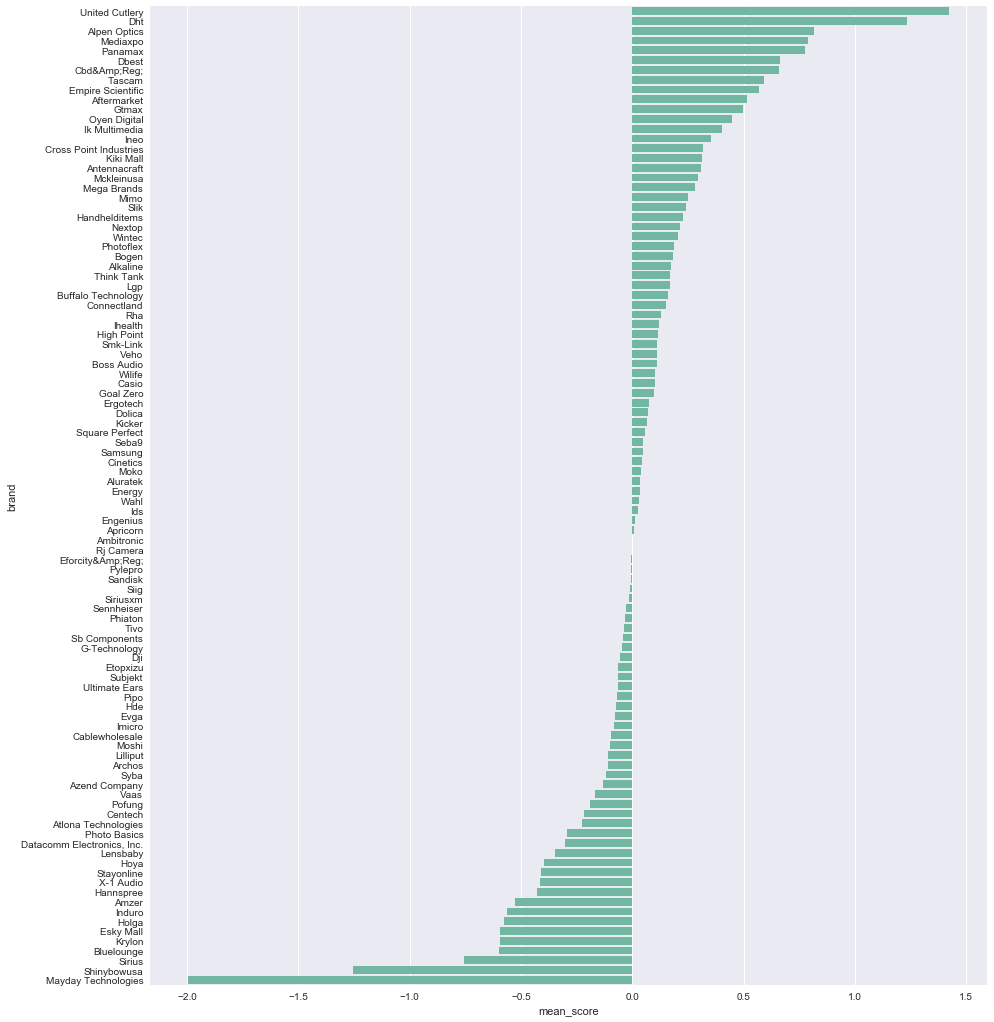

In [125]:
fig, ax = pyplot.subplots(figsize=(15,18))
sns.barplot(y="brand",x='mean_score', ax = ax,orient='h',data=df_brand_rank.sample(100,random_state=42).sort_values('mean_score',ascending=False),palette = sns.color_palette("BuGn_r", 1));
plt.show()

## Brand characteristics

In [126]:
# Group by brand
f = {'bigrams':'sum'}
df_brand_characteristics = df_final[['brand','bigrams']].groupby(['brand']).agg(f)
df_brand_characteristics = df_brand_characteristics.reset_index()

# Make sure to have unique characteristics and existing brand
df_brand_characteristics['characteristics'] = df_brand_characteristics.apply(lambda x : getCharacteristics(x['bigrams']), axis=1)
df_brand_characteristics = df_brand_characteristics[pd.notnull(df_brand_characteristics['characteristics'])]

In [137]:
display(df_brand_characteristics)

,brand,bigrams,characteristics
54,Amd,"[((dual, core), 2.112), ((dual, core), 0.37), ...","(dual core,3)"
75,Apple,"[((few, weeks), 0.026), ((large, hands), 0.072...","(angry birds,7)"
95,Asus,"[((high, quality), 0.14400000000000002), ((dro...","(dead pixels,8) / (high quality,5) / (fully ch..."
138,Belkin,"[((get, free), 0.13), ((different, colors), 0....","(high quality,10) / (well made,8) / (same time..."
150,Beyerdynamic,"[((tonal, balance), 0.034), ((large, diaphragm...","(new wave/techno,4)"
164,Bluerigger,"[((third, monitor), 0.055999999999999994), ((h...","(heavy duty,10)"
168,Bogen,"[((rapid, connect), 0.122), ((full, extension)...","(well made,3)"
200,Butterflyphoto,"[((original, canon), 0.298), ((main, tripod), ...","(extra battery,3)"
204,C2G,"[((well, made), 0.198), ((serial, cable), 1.38...","(well made,5) / (high quality,5) / (flat scree..."
218,Cablewholesale,"[((good, quality), 0.422), ((good, quality), 0...","(good quality,3)"


,brand,bigrams,characteristics
839,Neewer,"[((spherical, distortion), 0.08), ((focal, dis...","(extra batteries,3) / (live view,3)"
843,Netgear,"[((red, hat), 0.562), ((low, price), 0.3239999...","(dual band,5) / (western digital,4)"
854,Nikon,"[((good, condition), 0.262), ((old, nikon), 0....","(low light,25) / (wide angle,22) / (full frame..."
859,Noctua,"[((good, amount), 0.22799999999999998), ((stat...","(full speed,5) / (low noise,3)"
875,Olympus,"[((other, systems), 0.064), ((low, light), 0.1...","(low light,12) / (wide angle,6) / (manual focu..."
876,Omnimount,"[((flat, screen), 0.096), ((adhesive, strips),...","(flat screen,4)"
882,Op/Tech Usa,"[((come, loose), 0.062), ((soft, case), 0.674)...","(well made,5) / (high quality,3)"
898,Otterbox,"[((well, protected), 0.216), ((hard, plastic),...","(hard plastic,5) / (several times,3)"
905,Panasonic,"[((many, hours), 0.082), ((smaller, heads), 0....","(low light,15) / (wide angle,7) / (full frame,..."
919,Peerless,"[((flat, screen), 0.11), ((flat, screen), 0.25...","(flat screen,5) / (heavy duty,4)"


# Plan for milestone 3

By the next milestone, we will have improved several aspects of the analysis:

* We will improve the bigram analysis: extend it to trigram and compare n-gram scoring functions to see which one gives the best results for our data
* We will parallelize the pipeline, at least the characteristics extraction as it is currently the bottleneck of our analysis, to be able to run faster on the full Electronics review dataset
* We will finish the implementation of the brand ratings.

## Data story

We've opted for the data story and the idea is as follows:

We want to put into practice the idea stated in the introduction, namely to complement user feedback on e-commerce platforms. The story would go roughly as follows:

When visiting the presentation page, the user will be presented with a dummy e-commerce webpage with a product and some reviews. By scrolling down the page, the user will be able to see which collocations of the review are selected by our pipeline and how they contribute to the characterisation of the product. Finally, the user will be presented with a new dummy e-commerce webpage in which he will be able to see the full output of our processing pipeline for a few selected products. That is, characteristics of the product will be shown in addition to review and ratings. The more a characteristic is mentionned by the clients, the more it is emphasized on the webpage.